<a href="https://colab.research.google.com/github/wiederm/notebooks/blob/main/SAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:35
🔁 Restarting kernel...


In [ ]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
!mamba install -c conda-forge rdkit scikit-learn ngboost seaborn

Streaming output truncated to the last 5000 lines.
xorg-kbproto             [] (00m:00s) Waiting...
xorg-xproto              [] (00m:00s) Waiting...
future                   [] (00m:00s) Waiting...
ngboost                  [] (00m:00s) Waiting...
threadpoolctl            [] (00m:00s) Waiting...
xorg-libxext             [] (00m:00s) Waiting...
pillow                   [] (00m:00s) Waiting...
openjpeg                 [] (00m:00s) 
gettext                  [] (00m:02s) Waiting...
libglib                  [] (00m:02s) Decompressing...
libopenblas              [] (00m:02s) Waiting...
matplotlib-base          [] (00m:02s) Waiting...
pcre                     [] (00m:02s) Waiting...
python-dateutil          [] (00m:02s) Waiting...
pandas                   [] (00m:02s) Waiting...
pixman                   [] (00m:02s) Waiting...
rdkit                    [] (00m:02s)     25 MB /     38 MB (  9.09 MB/s)
scipy                    [] (00m:02s) Waiting...
seaborn-base             [] (00m:02s) Waiting.

In [ ]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.style.use('seaborn')

In [ ]:
# define molecule class that holds some data
class Molecule():

  def __init__(self, smiles:str, ic50:float):
    self.smiles = smiles
    self.ic50 = ic50
    self.molecule:Chem.Mol = Chem.MolFromSmiles(smiles)

# read in data from POLQ.txt
ligands = []
with open('POLQ.txt', 'r+') as f:
  for line in f.readlines()[1:]:
    values = line.split('\t')[1:]
    ligands.append(Molecule(values[0], float(values[1])))

[]

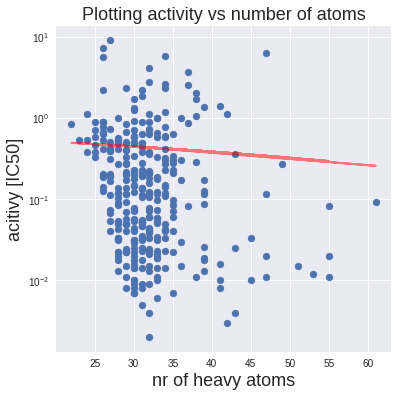

In [ ]:
# extract a list of tuples from the array of Molecules and save it in two lists x,y
x, y = (zip(*[(m.molecule.GetNumHeavyAtoms(), m.ic50) for m in ligands]))

# create a figure
plt.figure(figsize=(6,6))
fontsize=18
plt.scatter(x, y)
plt.title('Plotting activity vs number of atoms', fontsize=fontsize)
plt.ylabel('acitivy [IC50]', fontsize=fontsize)
plt.xlabel('nr of heavy atoms', fontsize=fontsize)
plt.yscale('log')
# calculate linear fit
m, b = np.polyfit(np.array(x), np.array(y), 1)
#m = slope, b=intercept
plt.plot(np.array(x), m*np.array(x) + b, color='r', alpha=0.5, linewidth=2)
# plot everything
plt.plot()

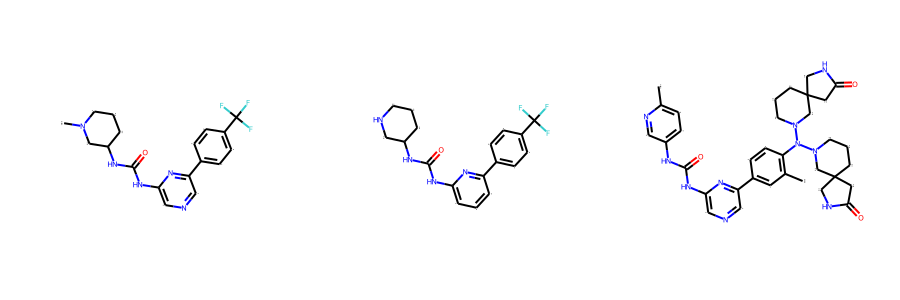

In [ ]:
# Draw some of the molecules
mols = [m.molecule for m in ligands][:3] # only the first three molecules are drawn
Draw.MolsToGridImage(mols,molsPerRow=3, subImgSize=(300,300))

In [ ]:
# shamelessly adopted from here: https://birdlet.github.io/2019/05/25/logs_prediction/

In [ ]:
# generate two arrays with ic50 in trainY and
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import AllChem, DataStructs, Descriptors, ReducedGraphs
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer
from sklearn.linear_model import LinearRegression

# generate MACCSKeys
def fingerprint(mol, fptype="MACCSKeys", radius=2, bits=1024):
    npfp = np.zeros((1,))
    if fptype == "MACCSKeys":
        DataStructs.ConvertToNumpyArray(AllChem.GetMACCSKeysFingerprint(mol), npfp)
    elif fptype == "Avalon":
        DataStructs.ConvertToNumpyArray(GetAvalonFP(mol), npfp)
    elif fptype == "ECFP":
        DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, radius, bits), npfp)
    elif fptype == "ErG":
        npfp = ReducedGraphs.GetErGFingerprint(mol)
    elif fptype == "Estate":
        npfp = Fingerprinter.FingerprintMol(mol)[0]
    else:
        raise TypeError()
    return npfp

# generate all rdkit descriptors that are availalble
def descriptors(mol):
    calc=MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    ds = np.asarray(calc.CalcDescriptors(mol))
    return ds




In [ ]:
def get_test_train_data(fptype ="ECFP"):
    """
    returns a tuple with (features_train, ic50_train), (features_test, ic50_test)
    features use the fingerprint specified in fptype, by default ECFP
    """

    # list with rdkit mol instances
    mols = [m.molecule for m in ligands]
    # list with tuple(fp, descriptor)
    feature = [np.append(fingerprint(mol, fptype), descriptors(mol)) for mol in mols]
    # only descriptor
    #feature = [descriptors(mol) for mol in mols]
    # only fp
    #feature = [fingerprint(mol, fptype) for mol in mols]
    # list with ic50 values
    ic50 = [-np.log10(m.ic50) for m in ligands]
    # choose a random seed
    np.random.seed(2)

    x = np.array(feature)
    y = np.array(ic50)

    # split the dataset in training/test data (80:20 split)
    features_train, features_test, ic50_train, ic50_test = train_test_split(x, y,
                                                        test_size=0.1,
                                                        random_state=2)

    return (features_train, ic50_train), (features_test, ic50_test)

In [ ]:
# get the test/training data
fptype='ECFP'
(features_train, ic50_train), (features_test, ic50_test) = get_test_train_data(fptype)

Train set R^2:  0.96517694050432
Train MAE score: 0.0597
Test set R^2:  -335.9802216778083
Test MAE score: 6.1173


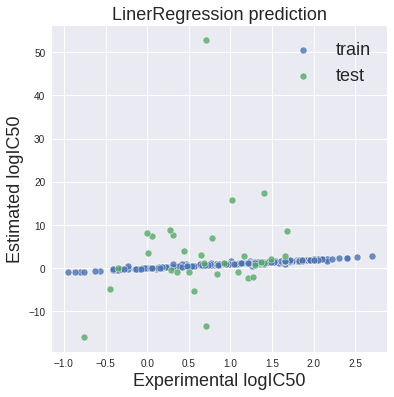

In [ ]:
# Basic linear regression

# initialize the model
model = LinearRegression()
# get the test/training data
# fit the model
model.fit(features_train, ic50_train)

y_pred_train = model.predict(features_train)
print("Train set R^2: ", r2_score(ic50_train, y_pred_train))
print("Train MAE score: %.4f" % mean_absolute_error(ic50_train, y_pred_train))

y_pred_test = model.predict(features_test)
print("Test set R^2: ", r2_score(ic50_test, y_pred_test))
print("Test MAE score: %.4f" % mean_absolute_error(ic50_test, y_pred_test))

fontsize=18
plt.figure(figsize=(6,6))
plt.title("LinerRegression prediction", fontsize=fontsize)
plt.xlabel("Experimental logIC50", fontsize=fontsize)
plt.ylabel("Estimated logIC50", fontsize=fontsize)
sns.scatterplot(x=ic50_train, y=model.predict(features_train),
            alpha=0.8, label="train")
sns.scatterplot(x=ic50_test, y=model.predict(features_test),
            alpha=0.8, label="test")
plt.legend(loc = 'best',fontsize=fontsize)
plt.show()


Train set R^2:  0.9076127486264811
Train MAE score: 0.1493
Test set R^2:  0.27487811501088977
Test MAE score: 0.4100


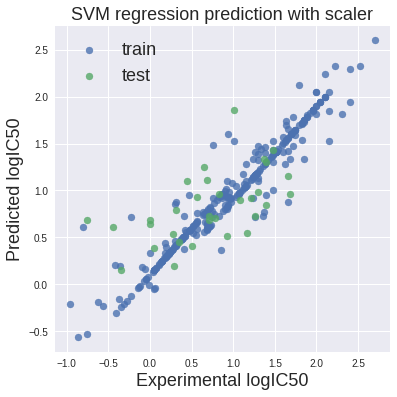

In [ ]:
# Support Vector Machine regression

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
stds = StandardScaler()

# initialize the model
model = SVR()
# standardize the features
stds.fit(features_train)
# fit the model
model.fit(stds.transform(features_train), ic50_train)

y_pred_train = model.predict(stds.transform(features_train))
print("Train set R^2: ", r2_score(ic50_train, y_pred_train))
print("Train MAE score: %.4f" % mean_absolute_error(ic50_train, y_pred_train))

y_pred_test = model.predict(stds.transform(features_test))
print("Test set R^2: ", r2_score(ic50_test, y_pred_test))
print("Test MAE score: %.4f" % mean_absolute_error(ic50_test, y_pred_test))

fontsize=18
plt.figure(figsize=(6,6))

plt.title("SVM regression prediction with scaler", fontsize=fontsize)
plt.xlabel("Experimental logIC50", fontsize=fontsize)
plt.ylabel("Predicted logIC50", fontsize=fontsize)
plt.scatter(ic50_train, y_pred_train,
            alpha=0.8, label="train")
plt.scatter(ic50_test, y_pred_test,
            alpha=0.8, label="test")
plt.legend(loc = 'best', fontsize=fontsize)
plt.show()


Train set R^2:  0.43158733637695523
Train MAE score: 0.4212
Test set R^2:  -0.5163246905252536
Test MAE score: 0.6130


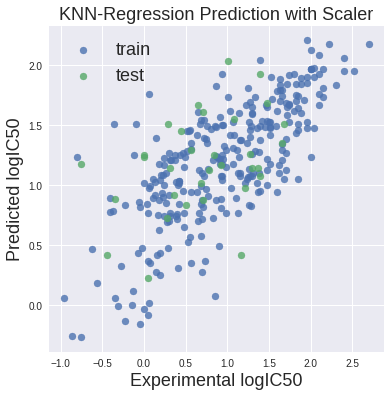

In [ ]:
from sklearn.neighbors import  KNeighborsRegressor

stds = StandardScaler()
model = KNeighborsRegressor()
stds.fit(features_train)

model.fit(stds.transform(features_train), ic50_train)

y_pred_train = model.predict(stds.transform(features_train))
print("Train set R^2: ", r2_score(ic50_train, y_pred_train))
print("Train MAE score: %.4f" % mean_absolute_error(ic50_train, y_pred_train))

y_pred_test = model.predict(stds.transform(features_test))
print("Test set R^2: ", r2_score(ic50_test, y_pred_test))
print("Test MAE score: %.4f" % mean_absolute_error(ic50_test, y_pred_test))

plt.figure(figsize=(6,6))

plt.title("KNN-Regression Prediction with Scaler", fontsize=fontsize)
plt.xlabel("Experimental logIC50", fontsize=fontsize)
plt.ylabel("Predicted logIC50", fontsize=fontsize)
plt.scatter(ic50_train, y_pred_train,
            alpha=0.8, label="train")
plt.scatter(ic50_test, y_pred_test,
            alpha=0.8, label="test")
plt.legend(loc = 'best', fontsize=fontsize)
plt.show()


Train set R^2:  0.9144421857351274
Train MAE score: 0.1550
Test set R^2:  0.2584263759247005
Test MAE score: 0.4109


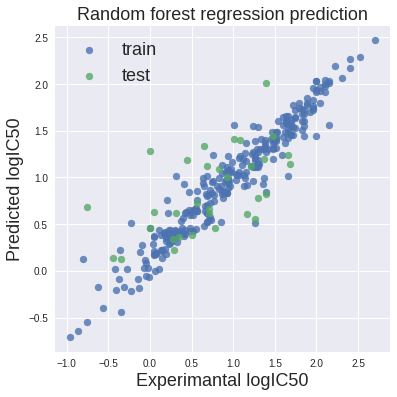

In [ ]:
# Random Forest Regression
# that's the method that seems to be most appropriate to use

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=200)
# get the test/training data
(features_train, ic50_train), (features_test, ic50_test) = get_test_train_data()

model.fit(features_train, ic50_train)

y_true, y_pred = ic50_test, model.predict(features_test)

y_pred_train = model.predict(features_train)
print("Train set R^2: ", r2_score(ic50_train, y_pred_train))
print("Train MAE score: %.4f" % mean_absolute_error(ic50_train, y_pred_train))

y_pred_test = model.predict(features_test)
print("Test set R^2: ", r2_score(ic50_test, y_pred_test))
print("Test MAE score: %.4f" % mean_absolute_error(ic50_test, y_pred_test))

plt.figure(figsize=(6,6))

plt.title("Random forest regression prediction", fontsize=fontsize)
plt.xlabel("Experimantal logIC50", fontsize=fontsize)
plt.ylabel("Predicted logIC50", fontsize=fontsize)
plt.scatter(ic50_train, y_pred_train,
            alpha=0.8, label="train")
plt.scatter(ic50_test, y_pred_test,
            alpha=0.8, label="test")
plt.legend(loc = 'best', fontsize=fontsize)
plt.show()


In [ ]:
len(model.feature_importances_)

1232

In [ ]:
len(Descriptors._descList)

208

[]

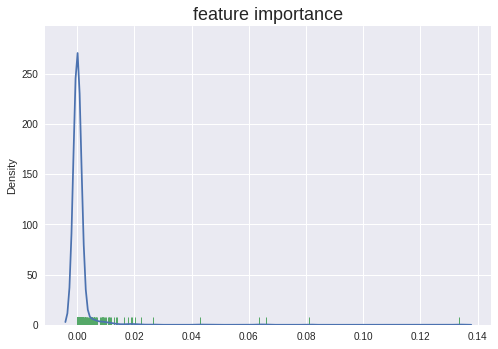

In [ ]:
sns.kdeplot(model.feature_importances_)
sns.rugplot(model.feature_importances_)
plt.title('feature importance', fontsize=fontsize)
plt.plot()

In [ ]:
model.fea

AttributeError: ignored